In [1]:
import os
import glob

import DESutils
import GPRutils
import vK2KGPR
import plotGPR
import vK2KGPR
import vonkarmanFT as vk

import numpy as np
import astropy.units as u
import astropy.table as tb
from astropy.time import Time
import matplotlib.pyplot as plt
plt.style.use('~/GitHub/custom-matplotlib/custom.mplstyle')

from IPython import embed
from importlib import reload
import warnings
warnings.filterwarnings("ignore")

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


In [ ]:
from scipy.signal import savgol_filter

In [2]:
# This function no longer needed but may be necessary.

# Takes in a load of exposures and finds the angle averaged two point correlation
# function for all pairs of points, across all exposures, with a separation less than
# rMax.

# def expAvg2ptCorr0(exps, rMax):
#     pairs0 = []
#     pairsf = []
#     for exp in exps:
#         dC = GPRutils.loadFITS(exp)
                
#         subsets = ["Subset A", "Subset B", "Subset C", "Subset D", "Subset E"]
#         for i in range(5):
#             x = dC.TV[dC.TV["Maskf"] & dC.TV[subsets[i]]]["fbar_s dX"]
#             y = dC.TV[dC.TV["Maskf"] & dC.TV[subsets[i]]]["fbar_s dY"]
#             dC.fbar_s = np.vstack([x, y]).T.value
            
#             x = dC.TV[dC.TV["Maskf"] & dC.TV[subsets[i]]]["X"]
#             y = dC.TV[dC.TV["Maskf"] & dC.TV[subsets[i]]]["Y"]
#             dC.Xvalid = np.vstack([x, y]).T.value
            
#             x = dC.TV[dC.TV["Maskf"] & dC.TV[subsets[i]]]["dX"]
#             y = dC.TV[dC.TV["Maskf"] & dC.TV[subsets[i]]]["dY"]
#             dC.Yvalid = np.vstack([x, y]).T.value

#             X = dC.Xvalid
#             Y = dC.Yvalid
#             Y2 = dC.Yvalid - dC.fbar_s

#             x, y = dC.Xvalid.T*u.deg
#             dx, dy = dC.Yvalid.T*u.mas
#             dx2, dy2 = (dC.Yvalid.T - dC.fbar_s.T)*u.mas

#             _, _, _, prs0 = GPRutils.getXi(X, Y, rMax=rMax)
#             _, _, _, prsf = GPRutils.getXi(X, Y2, rMax=rMax)
            
#             pairs0.append(Y[prs0[:, 0]] * Y[prs0[:, 1]])
#             pairsf.append(Y2[prsf[:, 0]] * Y2[prsf[:, 1]])
            
#     pairs0 = np.vstack(pairs0)
#     pairsf = np.vstack(pairsf)
    
#     xi0 = np.nanmean(np.sum(pairs0, axis=1))
#     Xerr, Yerr = np.nanstd(pairs0, axis=0) / np.sqrt(pairs0.shape[0])
#     xi0err = np.sqrt(Xerr**2 + Yerr**2)
    
#     xif = np.nanmean(np.sum(pairsf, axis=1))
#     Xerr, Yerr = np.nanstd(pairsf, axis=0) / np.sqrt(pairsf.shape[0])
#     xiferr = np.sqrt(Xerr**2 + Yerr**2)
    
#     return xi0, xi0err, xif, xiferr
# # xi0, xi0err, xif, xiferr = expAvg2ptCorr0(exps, rMax)

# From avgxi. No longer needed.
#     # Plot the all-pairs all-exposures estimate of xi+ at zero separation (xi_0)
#     plt.axhline(y=xi0, color="tab:red", label=r"Raw $\xi_0$: " + f"{xi0:0.3f} ± {xi0err:.3f} mas$^2$")
#     plt.axhline(y=xif, color="tab:blue", label=r"GPR $\xi_0$: " + f"{xif:0.3f} ± {xiferr:.3f} mas$^2$")

In [3]:
def expAvg2ptCorr(exps):
    xiplus0_arr = []
    xiplusf_arr = []
    r_arr = []
    for exp in exps:
        dC = GPRutils.loadFITS(exp)
                
        subsets = ["Subset A", "Subset B", "Subset C", "Subset D", "Subset E"]
        for i in range(5):
            x = dC.TV[dC.TV["Maskf"] & dC.TV[subsets[i]]]["fbar_s dX"]
            y = dC.TV[dC.TV["Maskf"] & dC.TV[subsets[i]]]["fbar_s dY"]
            dC.fbar_s = np.vstack([x, y]).T.value
            
            x = dC.TV[dC.TV["Maskf"] & dC.TV[subsets[i]]]["X"]
            y = dC.TV[dC.TV["Maskf"] & dC.TV[subsets[i]]]["Y"]
            dC.Xvalid = np.vstack([x, y]).T.value
            
            x = dC.TV[dC.TV["Maskf"] & dC.TV[subsets[i]]]["dX"]
            y = dC.TV[dC.TV["Maskf"] & dC.TV[subsets[i]]]["dY"]
            dC.Yvalid = np.vstack([x, y]).T.value

            X = dC.Xvalid
            Y = dC.Yvalid
            Y2 = dC.Yvalid - dC.fbar_s

            x, y = dC.Xvalid.T*u.deg
            dx, dy = dC.Yvalid.T*u.mas
            dx2, dy2 = (dC.Yvalid.T - dC.fbar_s.T)*u.mas

            result = GPRutils.calcCorrelation(x, y, dx, dy)
            xiplus0 = result[1]
            xiplus0_arr.append(xiplus0)

            result = GPRutils.calcCorrelation(x, y, dx2, dy2)
            xiplusf = result[1]
            xiplusf_arr.append(xiplusf)
            
            r = np.exp(result[0])
            r_arr.append(r)
            
    xiplus0 = np.nanmean(np.vstack(xiplus0_arr), axis=0)
    xiplusf = np.nanmean(np.vstack(xiplusf_arr), axis=0)
    r = np.nanmean(np.vstack(r_arr), axis=0)

    return xiplus0, xiplusf, r

In [4]:
def avgxi(
    rMax,
    xiplus0, xiplusf, r,
    window_length=25, polyorder=0,
    save=None
        ):

    plt.figure(figsize=(20, 10))

    # Plot the binned xi+
    plt.semilogx(r, xiplus0, color="tab:red", ls="", marker=".", label="Raw")
    plt.semilogx(r, xiplusf, color="tab:blue", ls="", marker=".", label="GPR Model Subtracted")
    
    xi0 = np.nanmean(xiplus0[r < rMax.value])
    xif = np.nanmean(xiplusf[r < rMax.value])
    # Plot the all-pairs all-exposures estimate of xi+ at zero separation (xi_0)
    plt.axhline(y=xi0, color="tab:red", label=r"Raw $\xi_0$: " + f"{xi0:0.3f} mas$^2$")
    plt.axhline(y=xif, color="tab:blue", label=r"GPR $\xi_0$: " + f"{xif:0.3f} mas$^2$")

    # Smooth the binned xi+ in order to get an accurate reading of the correlation length.
    smooth_xiplus0 = savgol_filter(xiplus0, window_length, polyorder)
    smooth_xiplusf = savgol_filter(xiplusf, window_length, polyorder)
    # Plot the smoothed xi+
    plt.semilogx(r, smooth_xiplus0, color="tab:red", ls="-")
    plt.semilogx(r, smooth_xiplusf, color="tab:blue", ls="-")

    # Calculate the correlation length based on the smoothed xi+.
    r0_0 = r[np.abs(smooth_xiplus0 - xi0/2).argmin()]
    r0_f = r[np.abs(smooth_xiplusf - xif/2).argmin()]
    # Plot the correlation lengths.
    plt.axvline(x=r0_0, c="tab:red", label=r"Raw $R_0$: " + f"{(r0_0*u.deg).to(u.arcmin):.3f}")
    plt.axvline(x=r0_f, c="tab:blue", label=r"GPR $R_0$: " + f"{(r0_f*u.deg).to(u.arcmin):.3f}")

#     # Plot xi_0/2 to match it up with the correlation length.
#     plt.axhline(y=xi0/2, c="tab:red", ls=":", label=r"Raw $0.5\xi_0$: " + f"{xi0/2:0.3f} mas$^2$")
#     plt.axhline(y=xif/2, c="tab:blue", ls=":", label=r"GPR $0.5\xi_0$: " + f"{xif/2:0.3f} mas$^2$")

    plt.axhline(y=0, color="k")

    plt.xlim(((5*u.arcsec).to(u.deg).value, (1.5*u.deg).to(u.deg).value))
    plt.ylim((None, None))

    plt.xlabel("r [deg]")
    plt.ylabel(r"$\xi_+(r)$ [mas$^2$]")

    plt.grid()
    plt.legend(loc="upper right")

    if save is not None:
        plt.savefig(save)
    plt.show()

/home/fortino/DESworkspace/utils/GPRutils.py:1932: RuntimeWarning: invalid value encountered in true_divide
  logr /= counts
/home/fortino/DESworkspace/utils/GPRutils.py:1938: RuntimeWarning: invalid value encountered in true_divide
  xiplus /= counts
/home/fortino/DESworkspace/utils/GPRutils.py:1943: RuntimeWarning: invalid value encountered in true_divide
  xiz2 /= counts
/home/fortino/DESworkspace/utils/GPRutils.py:1952: RuntimeWarning: invalid value encountered in true_divide
  ximinus /= counts


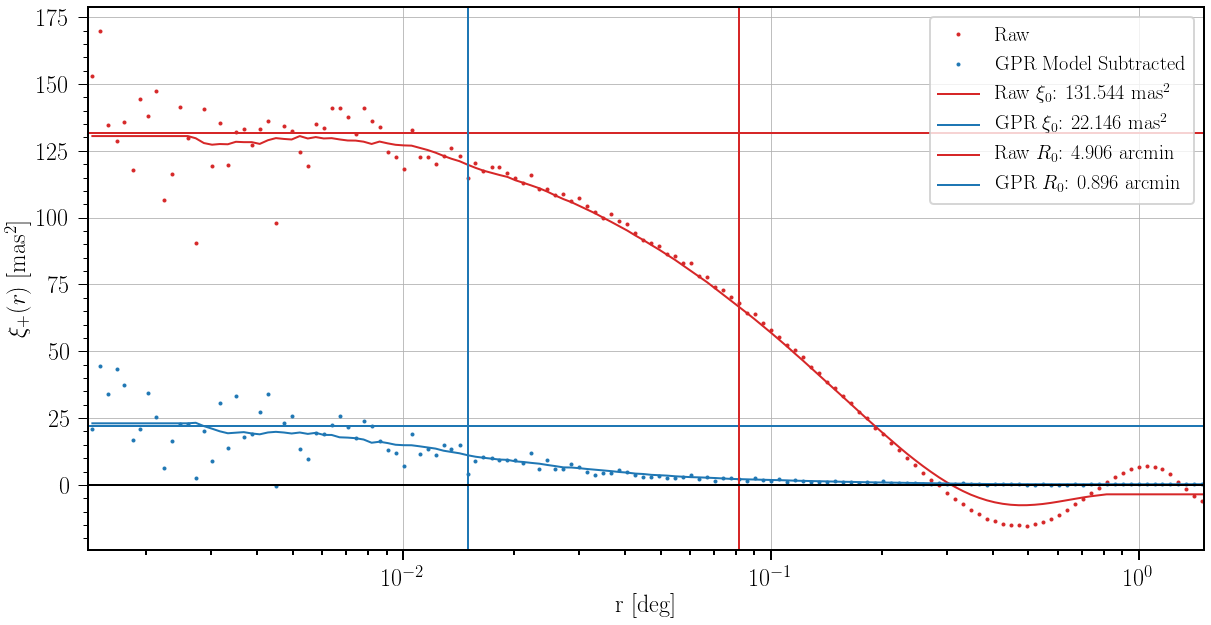

In [7]:
exps = glob.glob(f"/home/fortino/GPRSolutions/dualOpt_NMmax/GPR.??????.[g,r,i,z]RC.fits")
xiplus0, xiplusf, r = expAvg2ptCorr(exps)
rMax = (0.5*u.arcmin).to(u.deg)
avgxi(
    rMax,
    xiplus0, xiplusf, r,
#     save="/home/fortino/avgxi.png"
)

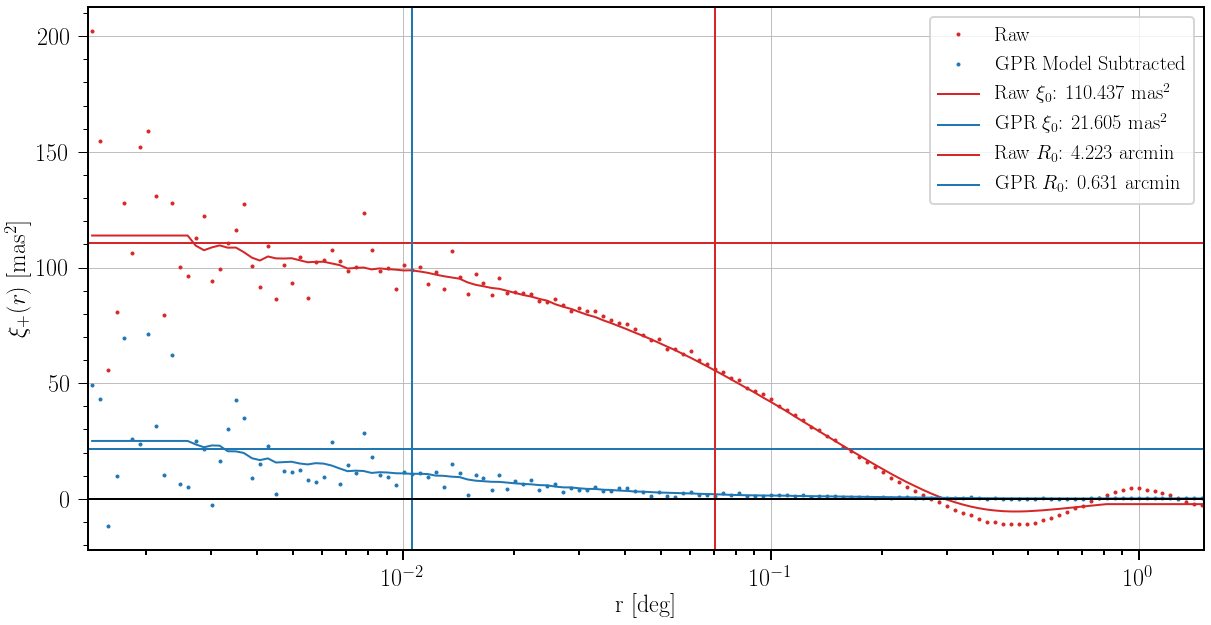

In [8]:
exps = glob.glob(f"/home/fortino/GPRSolutions/L_BFGS_B_max/GPR.??????.[g,r,i,z]RC.fits")
xiplus0, xiplusf, r = expAvg2ptCorr(exps)
rMax = (0.5*u.arcmin).to(u.deg)
avgxi(
    rMax,
    xiplus0, xiplusf, r,
#     save="/home/fortino/avgxi.png"
)